In [45]:
import os
import subprocess
import time
import glob
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

import itertools
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

# Import the Deeplsd model

In [46]:
# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  
    'line_detection_params': {
        'merge': False,  
        'filtering': True,  
        'grad_thresh': 3,
        'grad_nfa': True, 
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Import the desired data (Hypersim images)

In [47]:
#Parameters

frame_str = "0001"

# images
desired_images = [
    "ai_001_001",
    "ai_001_003",
    "ai_001_004",
    "ai_001_005",
    "ai_001_006",
    "ai_001_007",
    "ai_001_008",
    "ai_001_009",
    "ai_002_001",
    "ai_002_003",
    "ai_002_004",
    "ai_002_005",
    "ai_002_006",
    
]
desired_images = [
"ai_001_001",
"ai_001_003",
"ai_001_004",
"ai_001_005",
"ai_001_006",
"ai_001_007",
"ai_001_008",
"ai_001_009",
"ai_002_001",
"ai_002_003",
"ai_002_004",
"ai_002_005",
"ai_002_006",
"ai_002_007",
"ai_002_009",
"ai_003_001",
"ai_003_003",
"ai_003_004",
"ai_003_005",
"ai_003_006",
"ai_003_007",
"ai_003_008",
"ai_003_009",
"ai_004_001",
"ai_004_003",
"ai_004_004",
"ai_004_005",
"ai_004_006",
"ai_004_007",
"ai_004_008",
"ai_004_009",
"ai_005_001",
"ai_005_003",
"ai_005_004",
"ai_005_005",
"ai_005_006",
"ai_005_007",
"ai_005_008",
"ai_005_009",
"ai_006_001",
"ai_006_003",
"ai_006_004",
"ai_006_005",
"ai_006_006",
"ai_006_007",
"ai_006_008",
"ai_006_009",
"ai_007_001",
"ai_007_003"
    
]


files_to_download = [
    f"frame.{frame_str}.color.jpg",
    f"frame.{frame_str}.depth_meters.hdf5",
    f"frame.{frame_str}.normal_world.hdf5",
    f"frame.{frame_str}.normal_bump_world.hdf5",
    f"frame.{frame_str}.position.hdf5"
]

In [48]:

base_data_dir = "data"
if not os.path.exists(base_data_dir):
    os.makedirs(base_data_dir)
    print(f"Created base data folder: {base_data_dir}")
else:
    print(f"Base data folder {base_data_dir} already exists.")
    

Base data folder data already exists.


In [49]:

# Download Loop
for image_id in desired_images:
    # Create a folder for the image
    image_dir = os.path.join(base_data_dir, image_id)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
        print(f"Created folder: {image_dir}")
    else:
        print(f"Folder {image_dir} already exists.")

    # Try to download all the required files.
    for file_name in files_to_download:
        # Check if the file already exists.
        matching_files = glob.glob(os.path.join(image_dir, "**", file_name), recursive=True)
        if matching_files:
            print(f"File {file_name} already exists in {image_dir} (found: {matching_files[0]}). Skipping download.")
            continue

        # Build the command for download.py.
        cmd = [
            "python", "download.py",
            "--contains", image_id,
            "--contains", file_name,
            "--directory", image_dir,
            "--silent"
        ]
        print(f"Downloading {file_name} for {image_id} ...")
        proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE,
                                text=True, stdin=subprocess.DEVNULL)

        # Poll for file existence and stability.
        timeout = 1000  # seconds
        stable_iterations = 2  # number of consecutive checks required for stability
        stable_count = 0
        prev_size = -1
        start_time = time.time()
        while True:
            matching_files = glob.glob(os.path.join(image_dir, "**", file_name), recursive=True)
            if matching_files:
                # Check the file size of the first match.
                file_path = matching_files[0]
                try:
                    current_size = os.path.getsize(file_path)
                except OSError:
                    current_size = 0

                # If the file size is non-zero and hasn't changed since last check:
                if current_size > 0 and current_size == prev_size:
                    stable_count += 1
                else:
                    stable_count = 0  # Reset if it changed or if it's still zero

                prev_size = current_size

                if stable_count >= stable_iterations:
                    print(f"File {file_name} appears fully downloaded (stable size: {current_size} bytes). Terminating process.")
                    proc.terminate()  # terminate the download process if file is stable
                    break
            else:
                # No file found yet: reset stable count.
                stable_count = 0
                prev_size = -1

            if time.time() - start_time > timeout:
                print(f"Timeout reached while waiting for {file_name} in {image_dir}. Killing process.")
                proc.kill()
                break
            time.sleep(1)

        # Capture any remaining output.
        try:
            stdout, stderr = proc.communicate(timeout=5)
        except subprocess.TimeoutExpired:
            proc.kill()
            stdout, stderr = proc.communicate()

        if proc.returncode not in [0, None]:
            print(f"Process for {file_name} in {image_id} exited with return code {proc.returncode}.")


Folder data/ai_001_001 already exists.
File frame.0001.color.jpg already exists in data/ai_001_001 (found: data/ai_001_001/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg). Skipping download.
File frame.0001.depth_meters.hdf5 already exists in data/ai_001_001 (found: data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5). Skipping download.
File frame.0001.normal_world.hdf5 already exists in data/ai_001_001 (found: data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5). Skipping download.
File frame.0001.normal_bump_world.hdf5 already exists in data/ai_001_001 (found: data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5). Skipping download.
File frame.0001.position.hdf5 already exists in data/ai_001_001 (found: data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.position.hdf5). Skipping download.
Folder data/ai_001_003 already exists.
F

KeyboardInterrupt: 

# Define Helper Functions

In [ ]:
import os

import cv2
import h5py
import numpy as np
import pyvista as pv


def read_image(imname, resize_hw=None, max_image_dim=None, set_gray=False):
    img = cv2.imread(imname)
    if resize_hw is not None:
        img = cv2.resize(img, (resize_hw[1], resize_hw[0]))
    if (max_image_dim is not None) and max_image_dim != -1:
        hw_now = img.shape[:2]
        ratio = max_image_dim / max(hw_now[0], hw_now[1])
        if ratio < 1.0:
            h_new = int(round(hw_now[0] * ratio))
            w_new = int(round(hw_now[1] * ratio))
            img = cv2.resize(img, (w_new, h_new))
    if set_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def read_raydepth(raydepth_fname, resize_hw=None, max_image_dim=None):
    with h5py.File(raydepth_fname, "r") as f:
        raydepth = np.array(f["dataset"]).astype(np.float32)
    if resize_hw is not None and raydepth.shape != resize_hw:
        raydepth = cv2.resize(raydepth, (resize_hw[1], resize_hw[0]))
    if (max_image_dim is not None) and max_image_dim != -1:
        hw_now = raydepth.shape[:2]
        ratio = max_image_dim / max(hw_now[0], hw_now[1])
        if ratio < 1.0:
            h_new = int(round(hw_now[0] * ratio))
            w_new = int(round(hw_now[1] * ratio))
            raydepth = cv2.resize(raydepth, (w_new, h_new))
    return raydepth


def raydepth2depth(raydepth, K):
    K_inv = np.linalg.inv(K)
    h, w = raydepth.shape[0], raydepth.shape[1]
    grids = np.meshgrid(np.arange(w), np.arange(h))
    coords_homo = [grids[0].reshape(-1), grids[1].reshape(-1), np.ones(h * w)]
    coords_homo = np.stack(coords_homo)
    coeffs = np.linalg.norm(K_inv @ coords_homo, axis=0)
    coeffs = coeffs.reshape(h, w)
    depth = raydepth / coeffs
    return depth



In [55]:
import os
import glob
import cv2
import h5py

def find_file(image_dir, image_id,  pattern, cam_view):

    search_pattern = os.path.join(image_dir, image_id, "images", cam_view, pattern)
    print(search_pattern)
    files = glob.glob(search_pattern, recursive=True)
    return files[0] if files else None

def load_color_image(image_dir, image_id,  frame_str, cam_view):

    color_file = find_file(image_dir, image_id,  f"frame.{frame_str}.color.jpg", cam_view)
    if color_file is None:
        print("Color image not found in", image_dir, "with camera view", cam_view)
        return None
    img = cv2.imread(color_file)
    if img is None:
        print("Failed to load", color_file)
        return None
    # Convert from BGR to RGB
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_depth_map(image_dir, image_id, frame_str, cam_view):

    depth_file = find_file(image_dir,  image_id, f"frame.{frame_str}.depth_meters.hdf5", cam_view)
    if depth_file is None:
        print("Depth file not found in", image_dir, "with camera view", cam_view)
        return None
    with h5py.File(depth_file, 'r') as f:
        depth = np.array(f['dataset'])
    return depth.astype(np.float32)

def load_normal_map(image_dir,  image_id, frame_str, cam_view):

    normal_file = find_file(image_dir, image_id,  f"frame.{frame_str}.normal_world.hdf5", cam_view)
    if normal_file is None:
        print("Normal file not found in", image_dir, "with camera view", cam_view)
        return None
    with h5py.File(normal_file, 'r') as f:
        normal = np.array(f['dataset'])
    return normal.astype(np.float32)

def compute_variation(mapping, k, depth=False):
    """
    Computes the Sobel variation of a mapping (depth or normal) using a kernel size k.
    Normalizes the result by subtracting the mean and dividing by the standard deviation.
    """
   
    grad_x = cv2.Sobel(mapping, cv2.CV_64F, 1, 0, ksize=k)
    grad_y = cv2.Sobel(mapping, cv2.CV_64F, 0, 1, ksize=k)

    variation = np.sqrt(grad_x**2 + grad_y**2)

    
    # mean = np.mean(variation)
    # std_dev = np.std(variation)
    # normalized = (variation - mean) / std_dev
    # return normalized
    max_depth = 399742.56
    min_depth = 2.83e-12

    if depth:
        norm = (variation - min_depth) /(max_depth -min_depth)
    else:
        norm = (variation - 0) / (6.043567e+14 - 0)
    return norm

def sobel_line_old(sobel_depth, sobel_normal, line):
    """
    Returns the sobel values along that line for both depth and normal.
    """
    x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
    x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
    mask_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, 1)
    mask_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, 1)
    return mask_depth * sobel_depth, mask_normal * sobel_normal


def sobel_line(sobel_depth, sobel_normal, line, trim_ratio=0.25):
    """
    Computes the Sobel response in a trimmed neighborhood along a given line.

    Parameters:
        
    sobel_depth: 2D array of Sobel-filtered depth image.
    sobel_normal: 2D array of Sobel-filtered normal image.
    line: 2x2 array representing endpoints [[x1, y1], [x2, y2]].
    thickness: Line thickness for the neighborhood mask.
    trim_ratio: Ratio (0-0.5) to trim from both ends of the line.

        Returns:
        
    Tuple of masked Sobel depth and normal in the trimmed line neighborhood."""
    p1 = np.array(line[0], dtype=np.float32)
    p2 = np.array(line[1], dtype=np.float32)

    # Direction vector and length
    direction = p2 - p1
    length = np.linalg.norm(direction)
    unit_dir = direction / (length + 1e-8)

    # Shorten line by trim_ratio from both ends
    trim_len = length * trim_ratio
    new_p1 = p1 + unit_dir * trim_len
    new_p2 = p2 - unit_dir * trim_len

    # Convert to integer pixel coordinates
    x1, y1 = int(round(new_p1[0])), int(round(new_p1[1]))
    x2, y2 = int(round(new_p2[0])), int(round(new_p2[1]))

    # Create masks
    mask_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, 1)
    mask_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, 1)

    return mask_depth * sobel_depth, mask_normal * sobel_normal

def overlay_lines_on_image(image, lines, is_struct):
    """
    Overlays predicted lines on the image.
    """
    overlay = image.copy()
    for i, line in enumerate(lines):
        x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
        x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
        # In RGB: blue for structural, red for textural.
        color = (0, 0, 255) if is_struct[i] else (255, 0, 0)
        cv2.line(overlay, (x1, y1), (x2, y2), color, thickness=2)
    return overlay

#Plot results
def plot_lines_struct(lines, structural_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'red' for struct in structural_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)

# ===== Extension: Structural Line Classification Using Neighborhood Variation =====

def sobel_line_neighborhood(sobel_depth, sobel_normal, line, thickness=5):
    """
    """
    x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
    x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
    # Draw a thicker line mask to capture the neighborhood.
    mask_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, thickness=thickness)
    mask_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, thickness=thickness)
    return mask_depth * sobel_depth, mask_normal * sobel_normal



def overlay_lines_on_image_custom(image, lines, is_struct, line_color_struct, line_color_text):
    """
    Overlays predicted lines on the image using custom colors.
    """
    overlay = image.copy()
    for i, line in enumerate(lines):
        x1, y1 = int(round(line[0, 0])), int(round(line[0, 1]))
        x2, y2 = int(round(line[1, 0])), int(round(line[1, 1]))
        color = line_color_struct if is_struct[i] else line_color_text
        cv2.line(overlay, (x1, y1), (x2, y2), color, thickness=2)
    return overlay



def process_image(image_dir, image_id, frame_str, net, device,
                  depth_thresh, normal_thresh, thickness,
                  method="neighborhood", depth_normal_func = np.max,
                  depth_normal_func_str = "Max", norm_agg_func=np.sum,
                  struct_color=(0, 0, 255), text_color=(255, 0, 0),
                  display_result=True, plot_metrics=False):
    """
    Process a single image folder.

    Parameters:
      image_dir (str): Path to the image folder.
      frame_str (str): Frame number (e.g., "0001").
      net: The DeepLSD model.
      device: Torch device.
      depth_thresh (float): Threshold for depth variation.
      normal_thresh (float): Threshold for normal variation.
      thickness (int): Thickness (for neighborhood method).
      method (str): 'neighborhood' or 'original'. Determines which classification method to use.
      struct_color (tuple): Color for structural lines (default blue).
      text_color (tuple): Color for textural lines (default red).
      display_result (bool): If True, displays the composite image.
      plot_metrics (bool): If True, plots the max variation metrics for each detected line.

    Returns:
      composite (np.array): The composite image with overlaid lines, or None if data is missing.
    """
    # Load the image data
    cam_view_color = "scene_cam_00_final_preview"
    cam_view_geom = "scene_cam_00_geometry_hdf5"

    #hypersim = Hypersim("/data")

    color_img = load_color_image(image_dir, image_id, frame_str, cam_view_color)
    
    h, w = color_img.shape[:2]
    fov_x = np.pi / 3  # set fov_x to pi/3 to match DIODE dataset (60 degrees)
    f = w / (2 * np.tan(fov_x / 2))
    fov_y = 2 * np.arctan(h / (2 * f))
    default_K = np.array([[f, 0, w / 2], [0, f, h / 2], [0, 0, 1]])
    R180x = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])


    depth_map = load_depth_map(image_dir, image_id, frame_str, cam_view_geom)
    depth_map = raydepth2depth(depth_map, default_K)
    normal_map = load_normal_map(image_dir, image_id, frame_str, cam_view_geom)
    
    if color_img is None or depth_map is None or normal_map is None:
        print(f"Missing data in {image_dir}; skipping processing.")
        return None

    gray_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)


    
    # Detect lines with DeepLSD.
    input_tensor = torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.
    with torch.no_grad():
        out = net({'image': input_tensor})
        pred_lines = out['lines'][0]
        if isinstance(pred_lines, torch.Tensor):
            pred_lines = pred_lines.cpu().numpy()
    
    
    
    # Compute Sobel variation maps for depth and normal.
    sobel_depth_map = compute_variation(depth_map, 11)

    sobel_normal_map = compute_variation(normal_map, 27)

    sobel_normal_map = norm_agg_func(sobel_normal_map, axis=2)

    

    plot_images([sobel_depth_map], ["Depth sobel"], cmaps='gray')
    plot_images([(sobel_normal_map)], ['Normal sobel'], cmaps='gray')




        
        
    # Classify each predicted line and collect max metrics.
    is_struct = []
    depth_max_vals = []  # List to store max depth variation per line.
    normal_max_vals = []  # List to store max normal variation per line.
    
    if method == "neighborhood":
        # Use the neighborhood-based method.
        for l in pred_lines:
            ld_neigh, ln_neigh = sobel_line_neighborhood(sobel_depth_map, sobel_normal_map, l, thickness=thickness)
            max_depth = depth_normal_func(ld_neigh)
            max_normal = depth_normal_func(ln_neigh)
            depth_max_vals.append(max_depth)
            normal_max_vals.append(max_normal)
            depth_bool = max_depth > depth_thresh
            normal_bool = max_normal > normal_thresh
            is_struct.append(depth_bool or normal_bool)
    else:
        # Use the original line-based method.
        for l in pred_lines:
            ld_line, ln_line = sobel_line(sobel_depth_map, sobel_normal_map, l)
            max_depth = depth_normal_func(ld_line)
            max_normal = depth_normal_func(ln_line)
            depth_max_vals.append(max_depth)
            normal_max_vals.append(max_normal)
            depth_bool = max_depth > depth_thresh
            normal_bool = max_normal > normal_thresh
            is_struct.append(depth_bool or normal_bool)

    print(f"[{method.capitalize()} Method] {os.path.basename(image_dir)}: Detected {len(pred_lines)} lines; {sum(is_struct)} classified as structural.")

    
    
    # Create a composite image using custom overlay (with custom colors).
    composite = overlay_lines_on_image_custom(color_img, pred_lines, is_struct,
                                               line_color_struct=struct_color,
                                               line_color_text=text_color)
    
    
    
    # Optionally display the composite image.
    if display_result:
        plt.figure(figsize=(10, 10))
        plt.imshow(composite)
        plt.title(f"{os.path.basename(image_dir)} - Frame {frame_str}: Structural vs Textural")
        plt.axis("off")
        plt.show()
    
    
    
    # Optionally, plot the max variation metrics.
    if plot_metrics and len(depth_max_vals) > 0:
        plt.figure(figsize=(8, 6))
        # Plot structural lines in one color and textural in another.
        for i in range(len(depth_max_vals)):
            if is_struct[i]:
                plt.scatter(depth_max_vals[i], normal_max_vals[i], c='blue', marker='o', label='Structural' if i==0 else "")
            else:
                plt.scatter(depth_max_vals[i], normal_max_vals[i], c='red', marker='x', label='Textural' if i==0 else "")
        plt.xlabel(f"{depth_normal_func_str} Depth Variation")
        plt.ylabel(f"{depth_normal_func_str} Normal Variation")
        plt.title(f"{os.path.basename(image_dir)} - Frame {frame_str} - Thickness {thickness}: Variation Metrics")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return composite

def sigmoid(x, lam=10, tau=0.01):
    """
    Compute sigmoid function for soft thresholding.
    - lam: scaling factor (higher = sharper transition)
    - tau: threshold shift
    """
    return 1 / (1 + np.exp(-lam * (x - tau)))

# Visualization
def plot_lines_confidence(img, lines, confidences, indices=(0, 1), alpha=1):
    """ Plots lines with color intensity based on confidence scores """
    fig, ax = plt.subplots()
    #norm = plt.Normalize(min(confidences), max(confidences))
    cmap = plt.cm.get_cmap("coolwarm")
    
    for i, l in enumerate(lines):
        color = cmap((confidences[i]))
        line = plt.Line2D((l[0, 0], l[1, 0]), (l[0, 1], l[1, 1]), linewidth=2, color=color, alpha=alpha)
        ax.add_line(line)
    
    ax.imshow(img, cmap='gray')
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, label='Confidence Score')
    plt.show()


In [56]:
def plot_process(image_ids, base_data_dir, depth_thresholds, normal_thresholds,
                thickness_values, n_columns=2, depth_normal_func=np.max, depth_normal_func_str="Max",
                norm_agg_func=np.sum):
    
    for image_id in image_ids:
        image_dir = os.path.join(base_data_dir, image_id)
        print(f"\n[Parameter Comparison] Processing image: {image_id} for frame {frame_str}")

        # Lists to store the composite images and their corresponding titles
        composite_images = []
        titles = []
        plot = True # Only plot the first time
        # Iterate over the Cartesian product of all parameter arrays
        for d_thresh, n_thresh, t_val in itertools.product(depth_thresholds, normal_thresholds, thickness_values):
            # Process the image with the current set of parameters

            composite = process_image(
                image_dir, image_id, frame_str, net, device,
                depth_thresh=d_thresh,
                normal_thresh=n_thresh,
                thickness=t_val,
                method="neighborhood",
                depth_normal_func=depth_normal_func,
                depth_normal_func_str=depth_normal_func_str,
                norm_agg_func=norm_agg_func,
                struct_color=(0, 0, 255),  # blue
                text_color=(255, 0, 0),    # red
                display_result=False,
                plot_metrics=plot
            )
            plot=False # no need to plot more than once

            if composite is not None:
                composite_images.append(composite)
                titles.append(f"d={d_thresh}, n={n_thresh}, t={t_val}")

        # If we got any composite images, create a grid for comparison
        n_composites = len(composite_images)
        if n_composites > 0:
            # Define the grid with 2 columns
            n_cols = n_columns
            n_rows = int(np.ceil(n_composites / n_cols))
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))
            # Flatten the axes array in case it is multidimensional.
            axs = np.array(axs).flatten()
            for i, comp in enumerate(composite_images):
                axs[i].imshow(comp)
                axs[i].set_title(titles[i])
                axs[i].axis("off")
            # Hide any unused subplots.
            for j in range(n_composites, len(axs)):
                axs[j].axis("off")
            plt.suptitle(f"{image_id} - Frame {frame_str} Parameter Comparison", fontsize=16)
            plt.tight_layout()
            plt.show()

            # save the grid of composite images.
            grid_out_path = os.path.join(image_dir, f"parameter_comparison_{frame_str}.png")
            fig.savefig(grid_out_path)
            print(f"Saved parameter comparison grid to {grid_out_path}")

# Process all images

# First method


Processing image: ai_001_001 for frame 0001
data/ai_001_001/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 398 lines; 0 classified as structural.


/var/folders/qb/d4hwnh6j08gd2t6xyjf8s4j00000gn/T/ipykernel_16071/546528927.py:346: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("coolwarm")


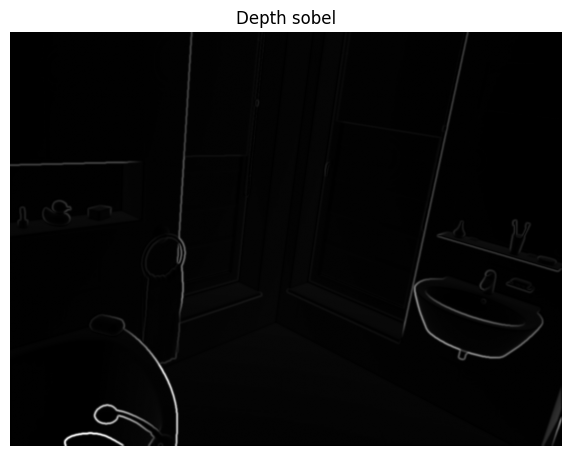

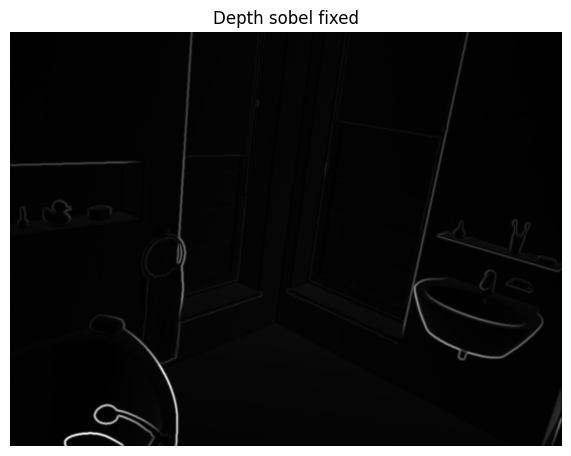

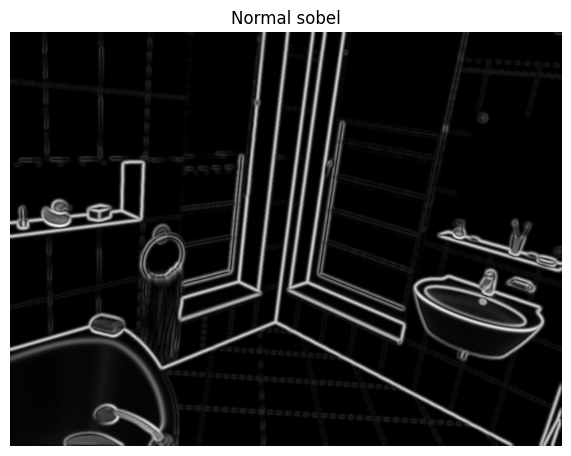

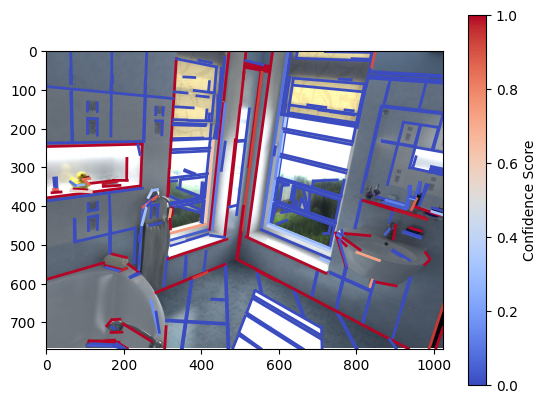


Processing image: ai_001_003 for frame 0001
data/ai_001_003/ai_001_003/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_003/ai_001_003/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_003/ai_001_003/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 375 lines; 0 classified as structural.


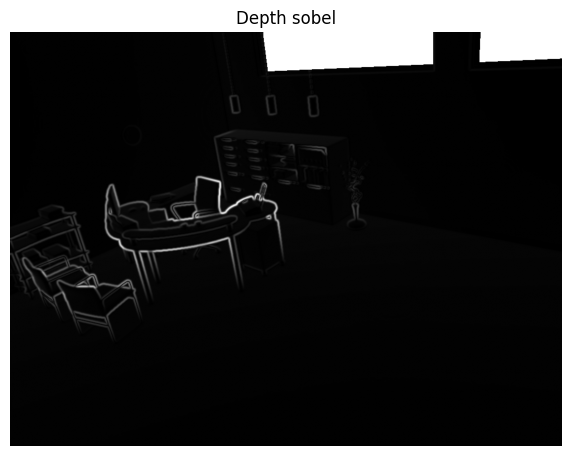

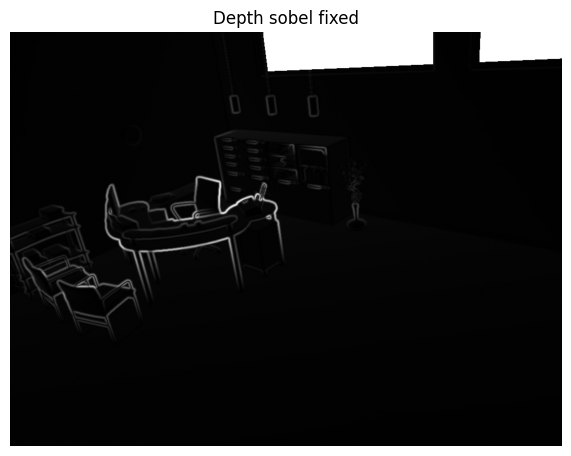

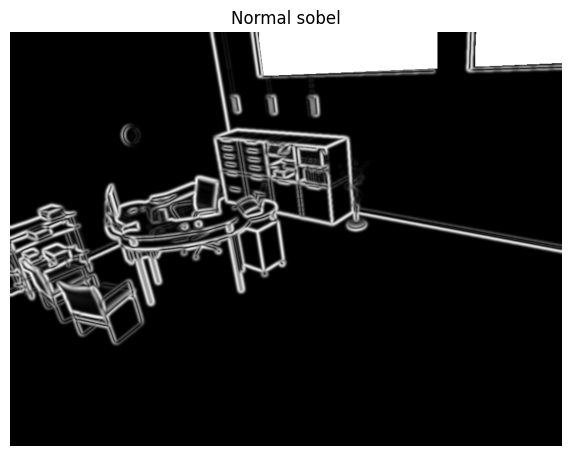

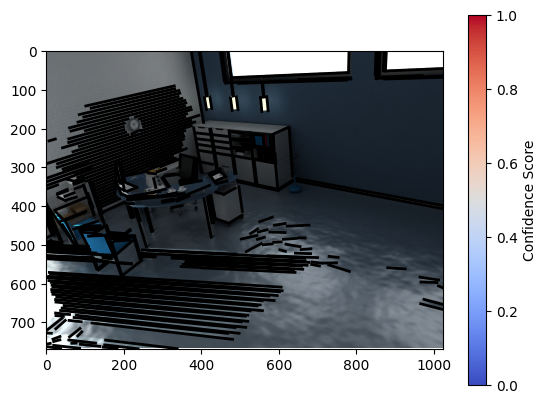


Processing image: ai_001_004 for frame 0001
data/ai_001_004/ai_001_004/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_004/ai_001_004/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_004/ai_001_004/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 376 lines; 0 classified as structural.


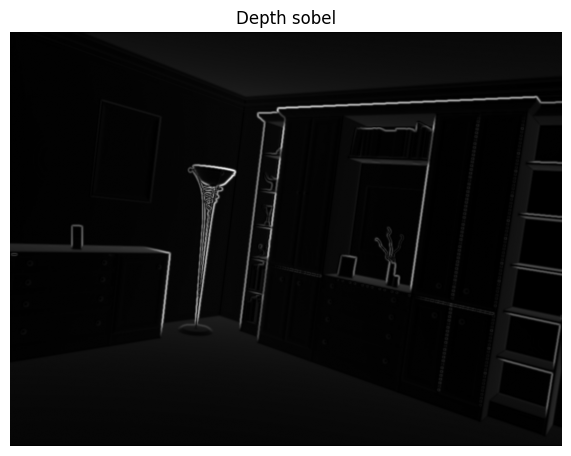

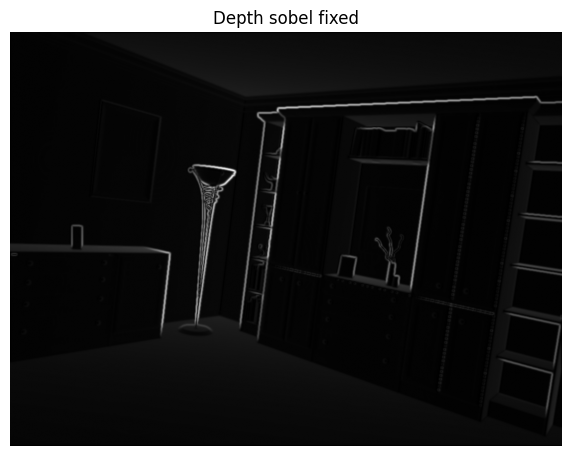

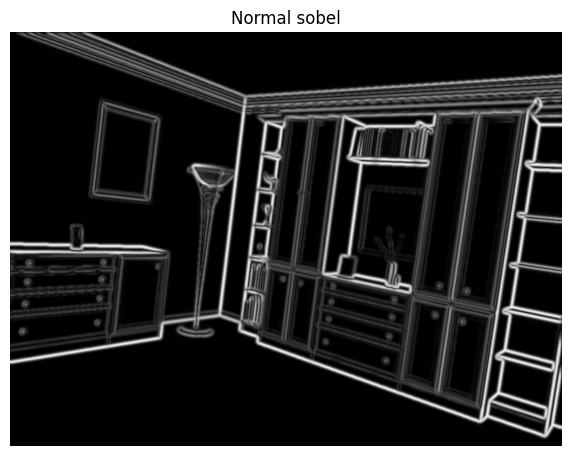

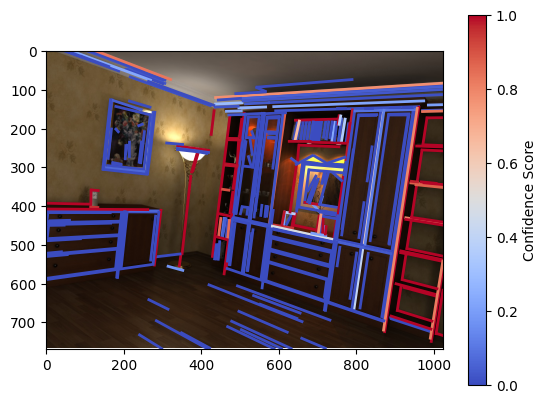


Processing image: ai_001_005 for frame 0001
data/ai_001_005/ai_001_005/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_005/ai_001_005/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_005/ai_001_005/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 461 lines; 0 classified as structural.


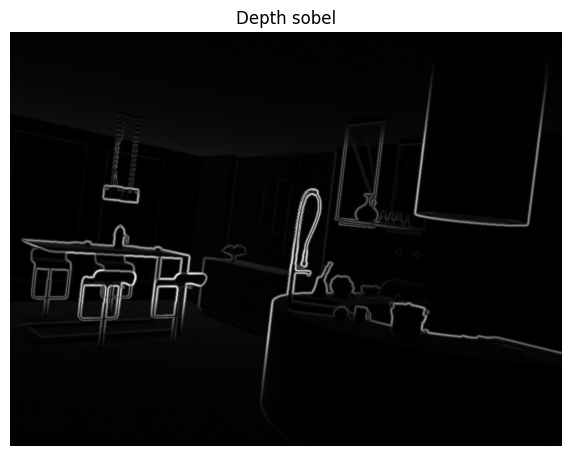

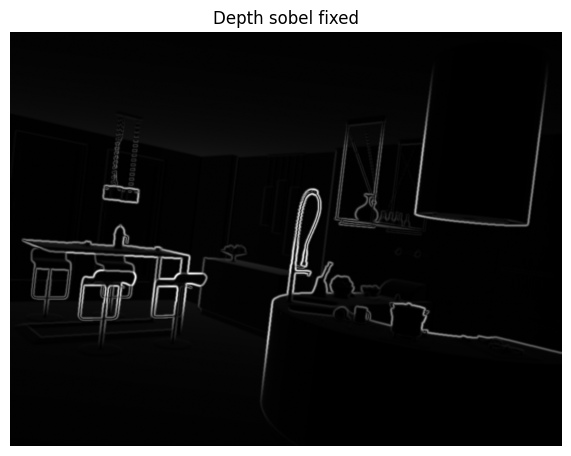

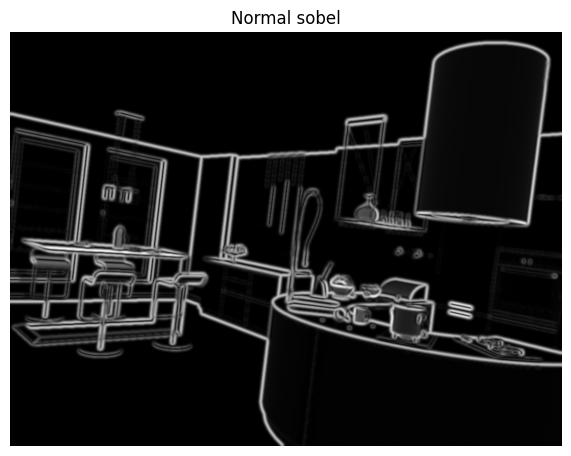

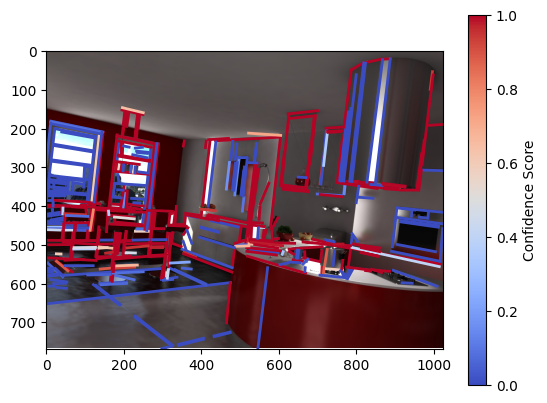


Processing image: ai_001_006 for frame 0001
data/ai_001_006/ai_001_006/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_006/ai_001_006/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_006/ai_001_006/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 482 lines; 0 classified as structural.


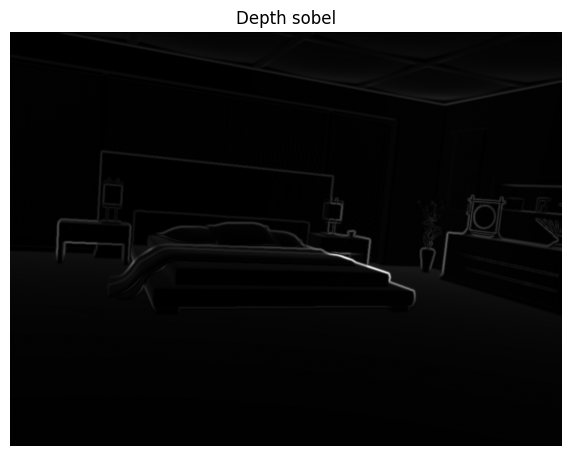

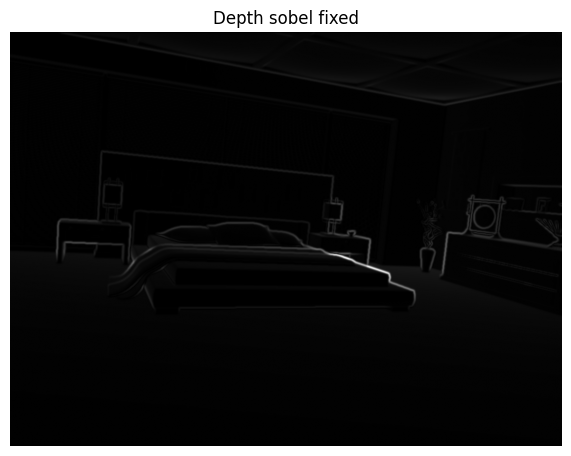

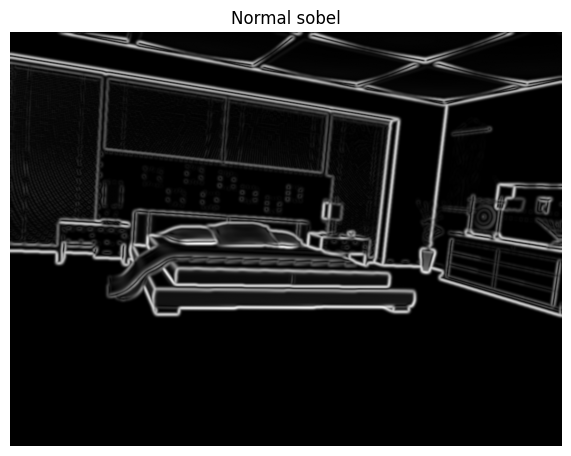

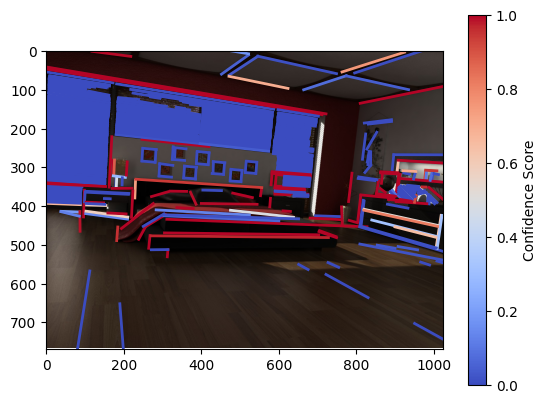


Processing image: ai_001_007 for frame 0001
data/ai_001_007/ai_001_007/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_007/ai_001_007/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_007/ai_001_007/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 493 lines; 0 classified as structural.


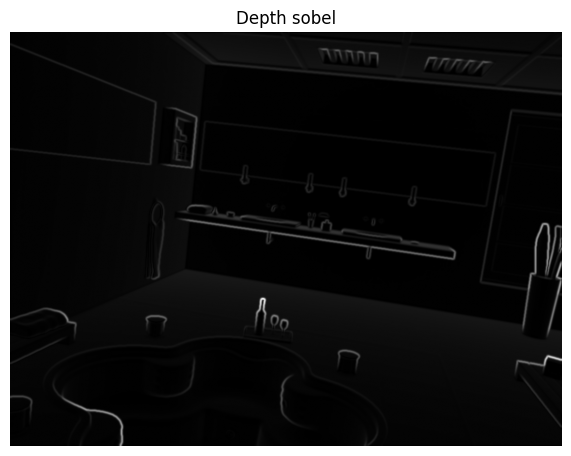

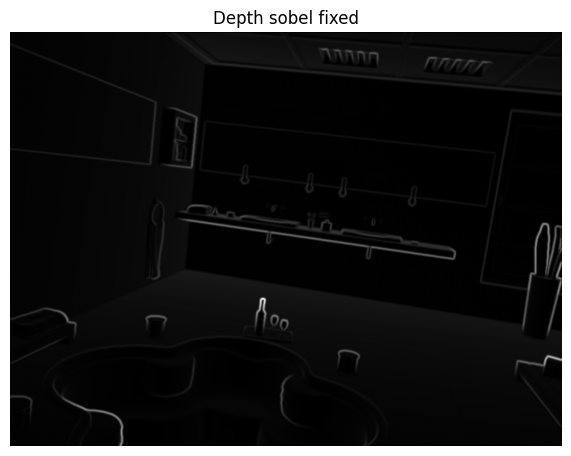

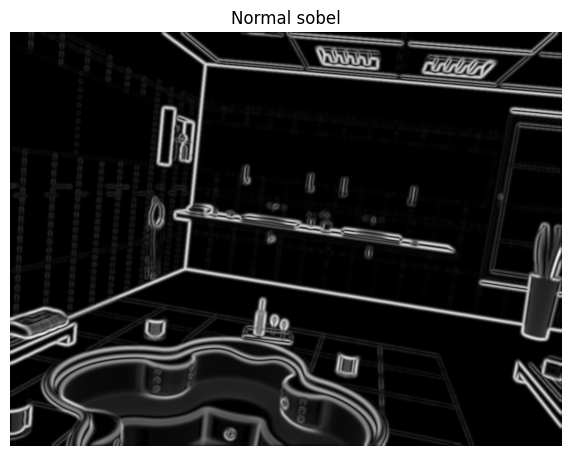

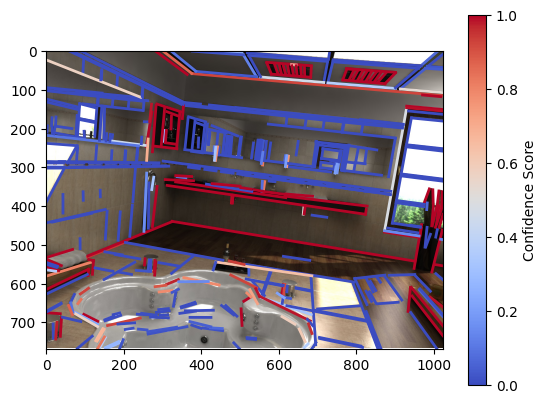


Processing image: ai_001_008 for frame 0001
data/ai_001_008/ai_001_008/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_008/ai_001_008/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_008/ai_001_008/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 435 lines; 0 classified as structural.


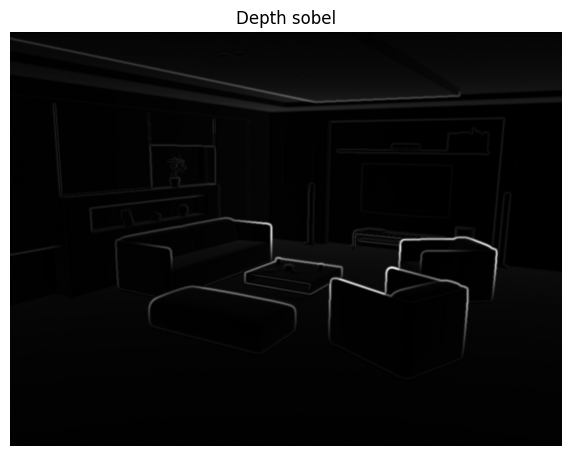

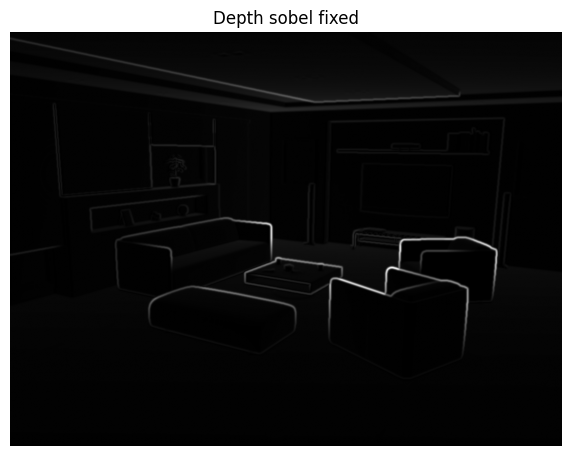

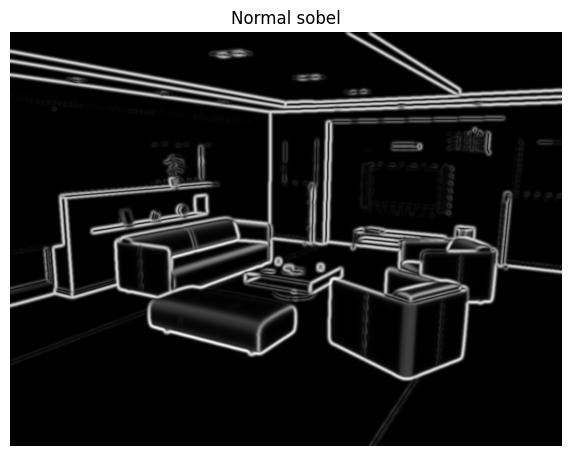

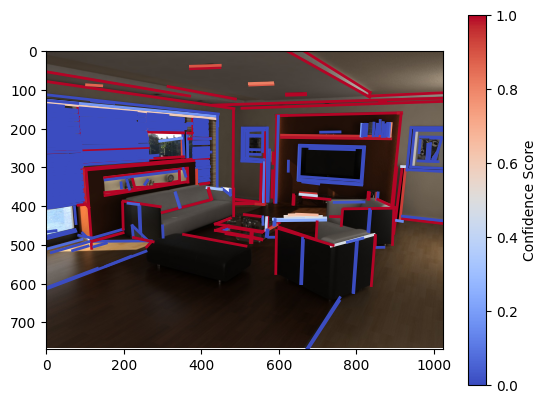


Processing image: ai_001_009 for frame 0001
data/ai_001_009/ai_001_009/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_009/ai_001_009/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_001_009/ai_001_009/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 189 lines; 0 classified as structural.


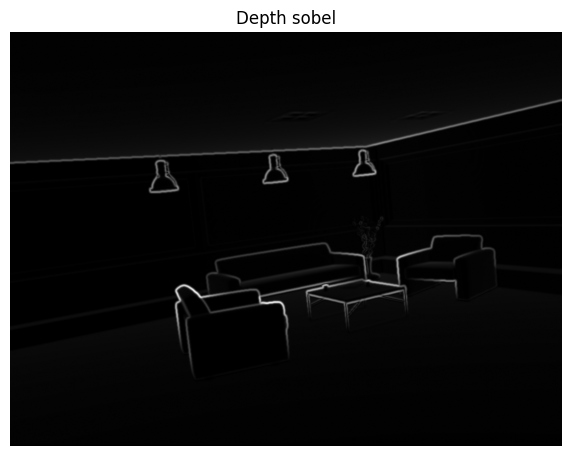

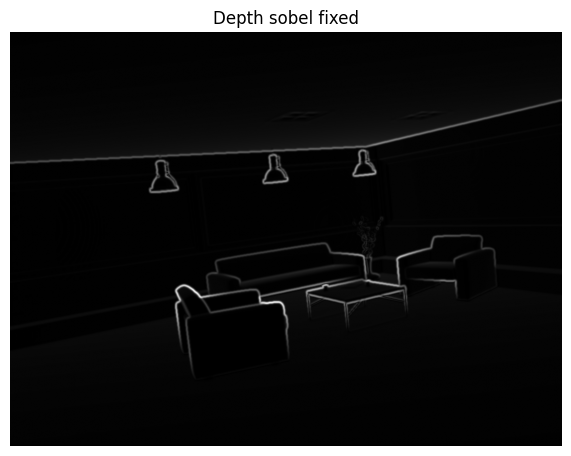

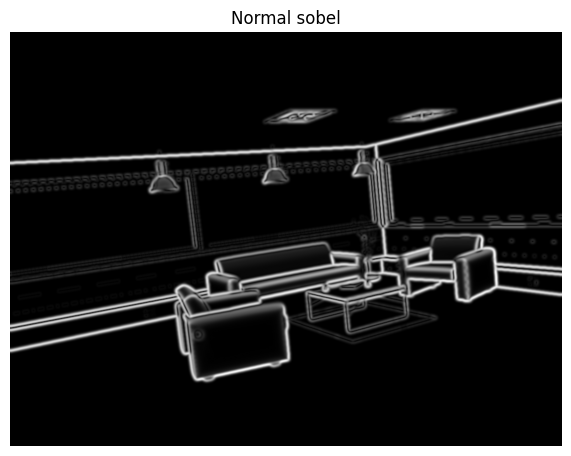

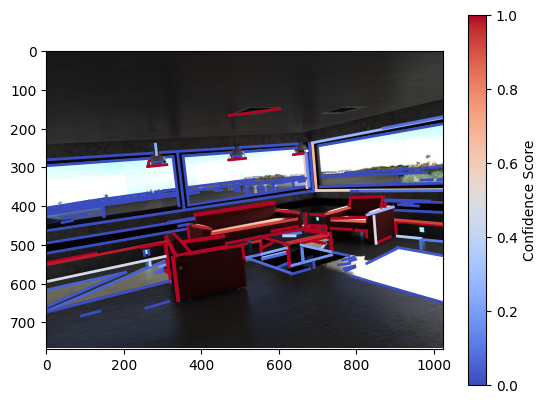


Processing image: ai_002_001 for frame 0001
data/ai_002_001/ai_002_001/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_002_001/ai_002_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_002_001/ai_002_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 500 lines; 0 classified as structural.


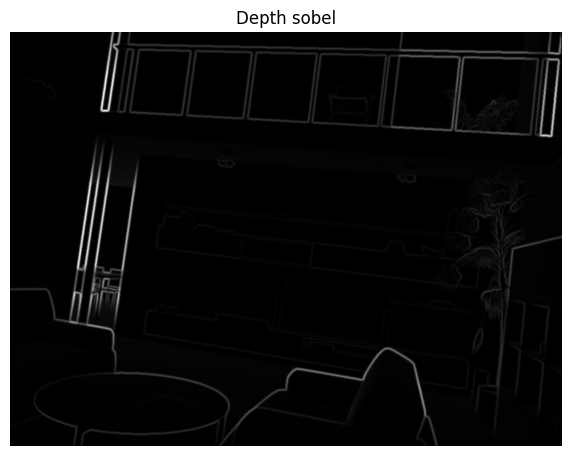

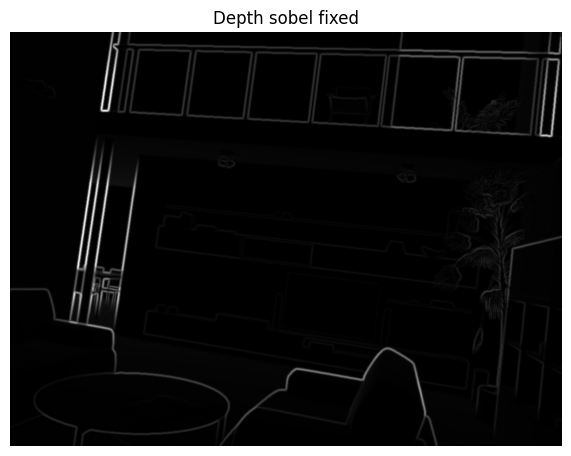

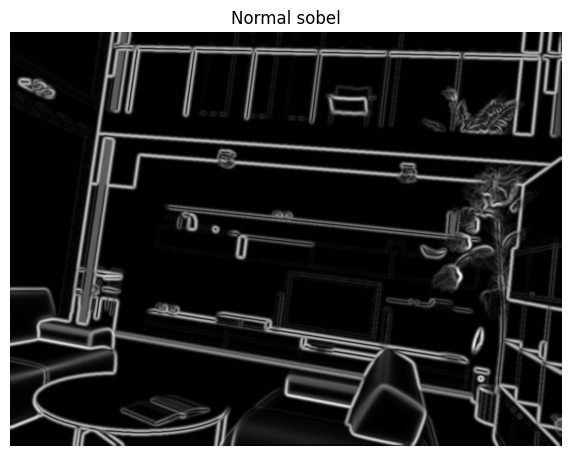

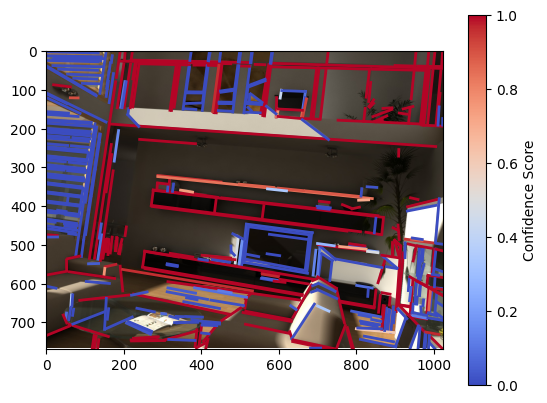


Processing image: ai_002_003 for frame 0001
data/ai_002_003/ai_002_003/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_002_003/ai_002_003/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_002_003/ai_002_003/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 888 lines; 0 classified as structural.


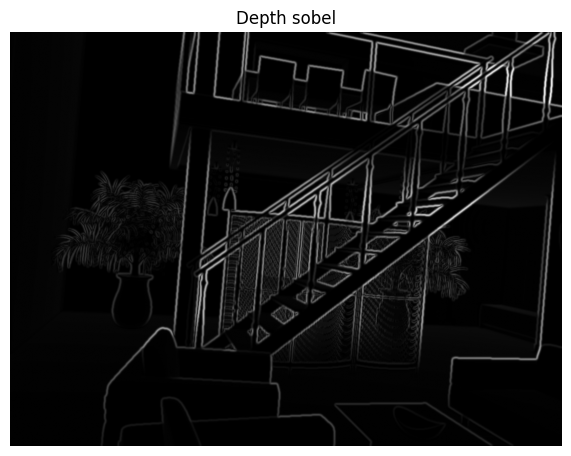

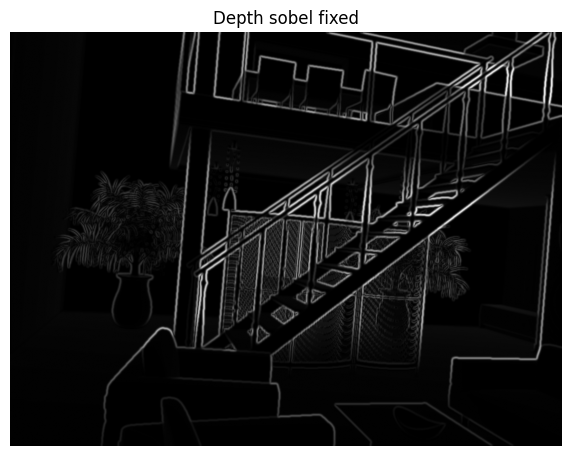

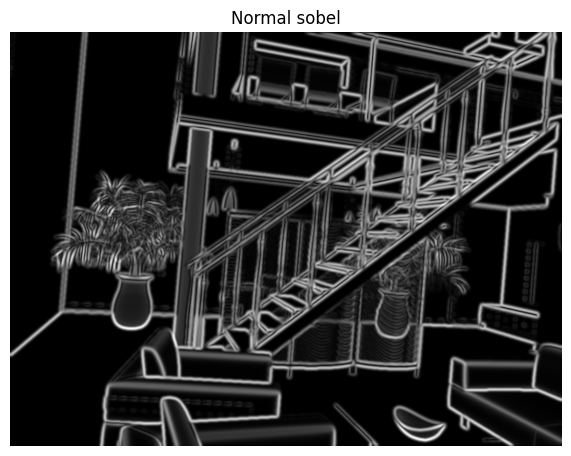

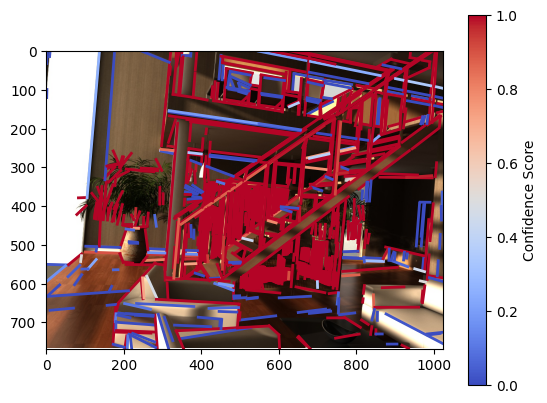


Processing image: ai_002_004 for frame 0001
data/ai_002_004/ai_002_004/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_002_004/ai_002_004/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_002_004/ai_002_004/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 758 lines; 0 classified as structural.


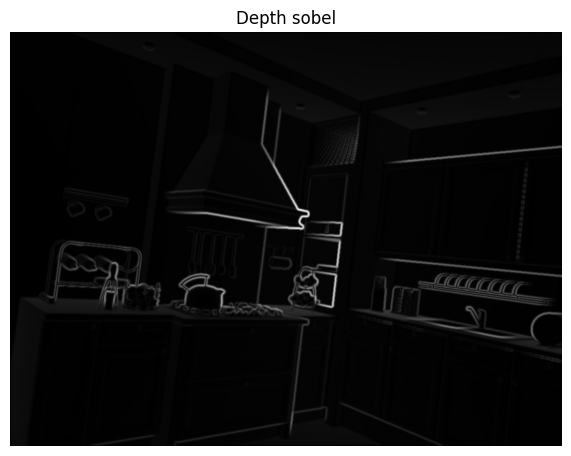

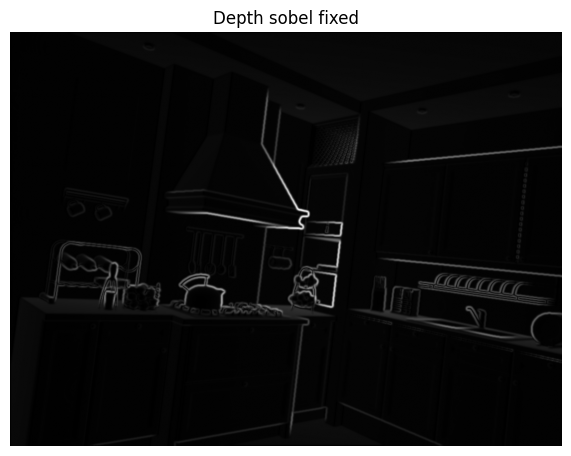

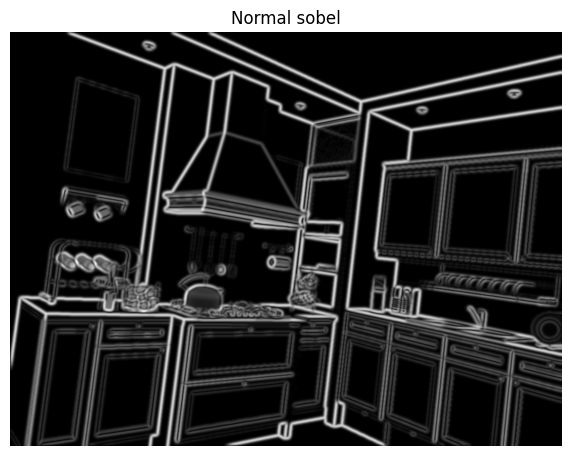

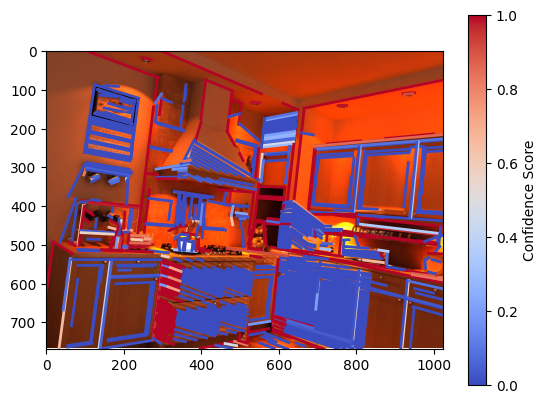


Processing image: ai_002_005 for frame 0001
data/ai_002_005/ai_002_005/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_002_005/ai_002_005/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_002_005/ai_002_005/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 498 lines; 0 classified as structural.


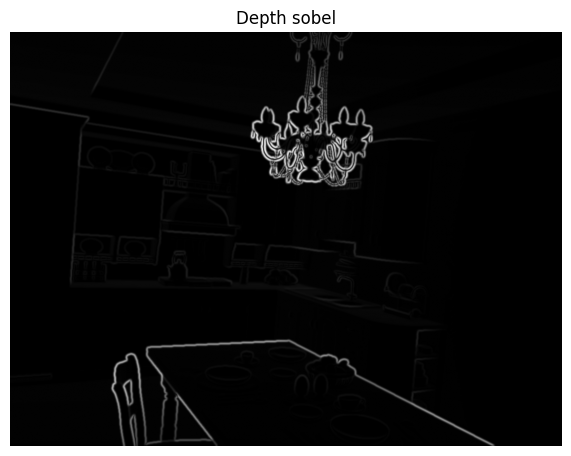

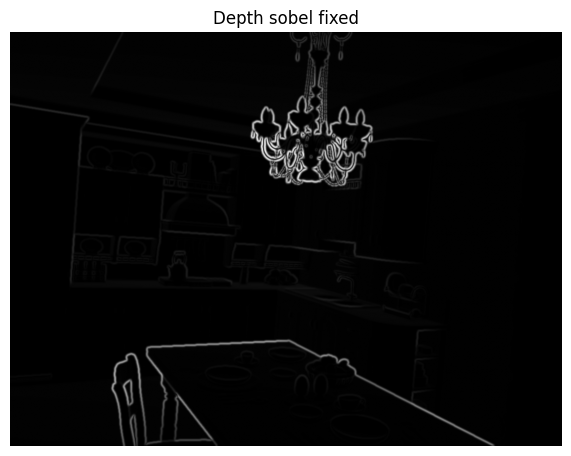

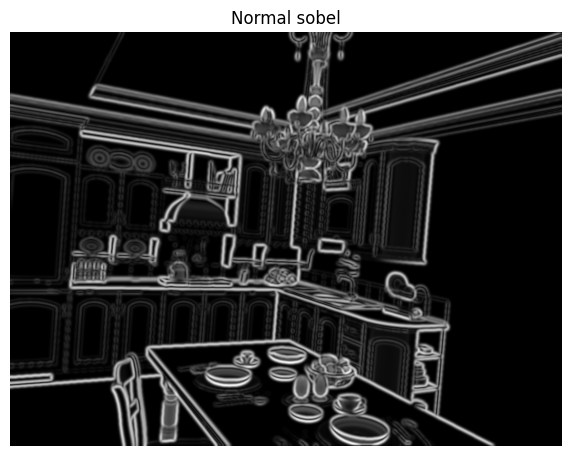

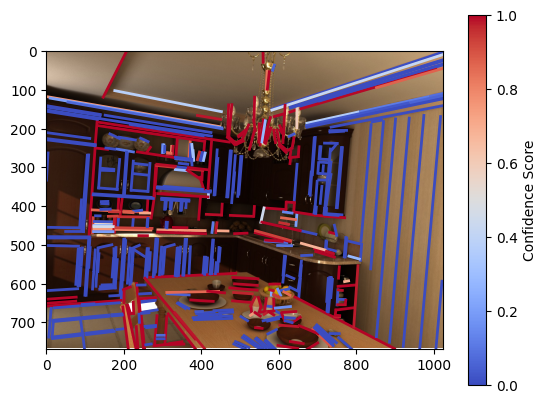


Processing image: ai_002_006 for frame 0001
data/ai_002_006/ai_002_006/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_002_006/ai_002_006/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_002_006/ai_002_006/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 395 lines; 0 classified as structural.


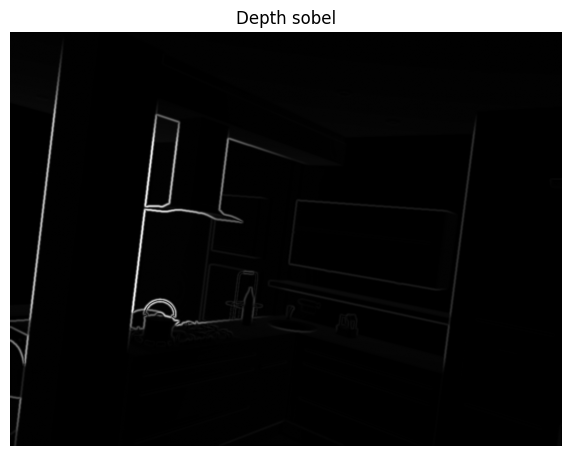

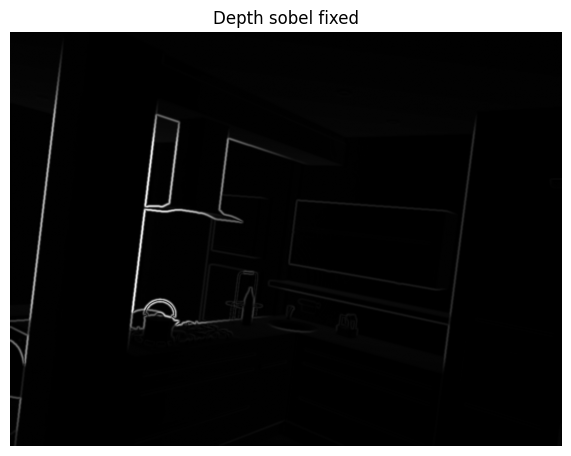

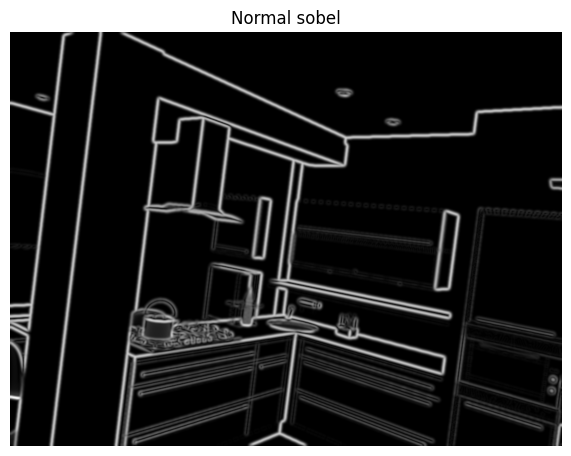

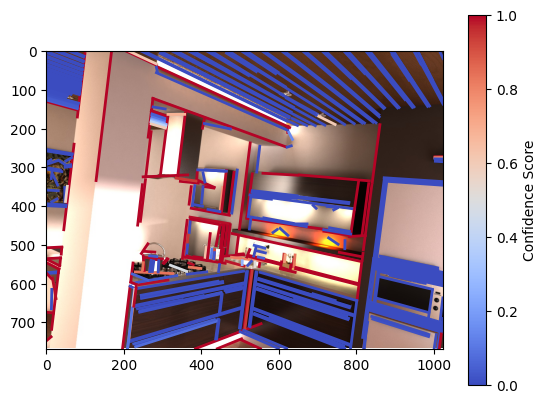


Processing image: ai_002_007 for frame 0001
data/ai_002_007/ai_002_007/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_002_007/ai_002_007/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_002_007/ai_002_007/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 711 lines; 0 classified as structural.


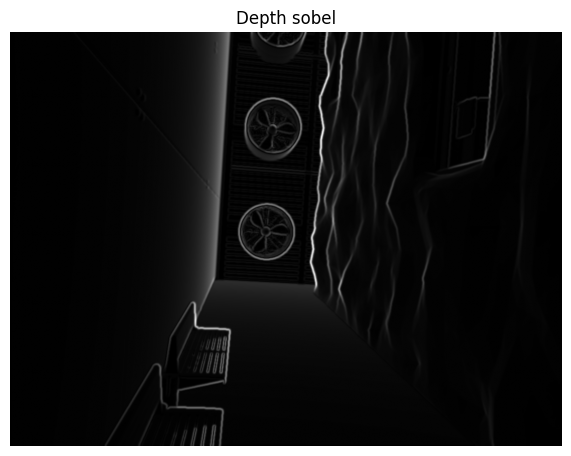

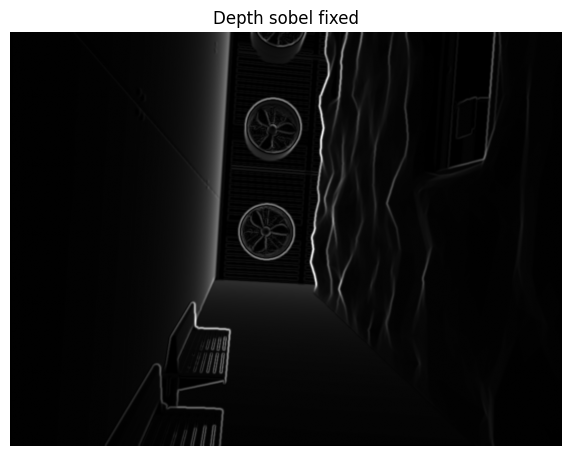

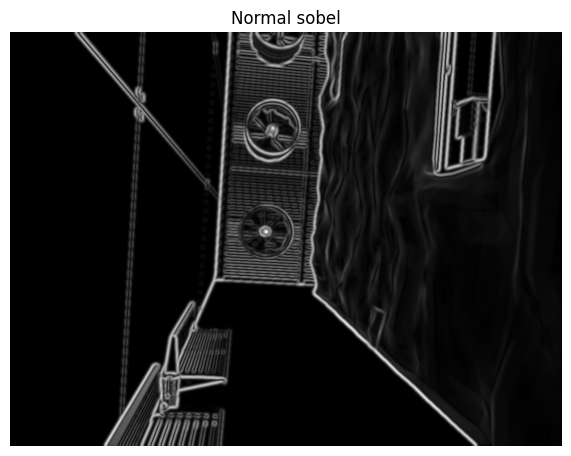

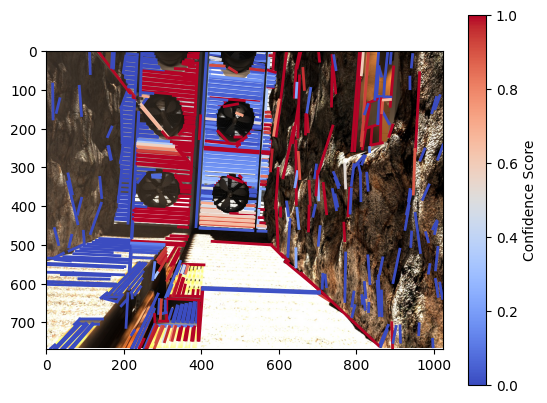


Processing image: ai_002_009 for frame 0001
data/ai_002_009/ai_002_009/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_002_009/ai_002_009/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_002_009/ai_002_009/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 311 lines; 0 classified as structural.


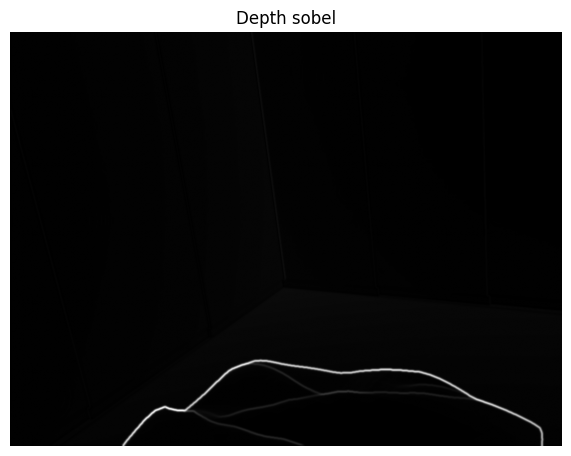

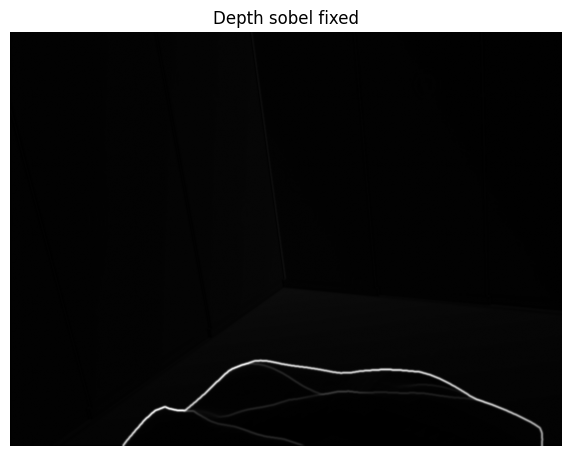

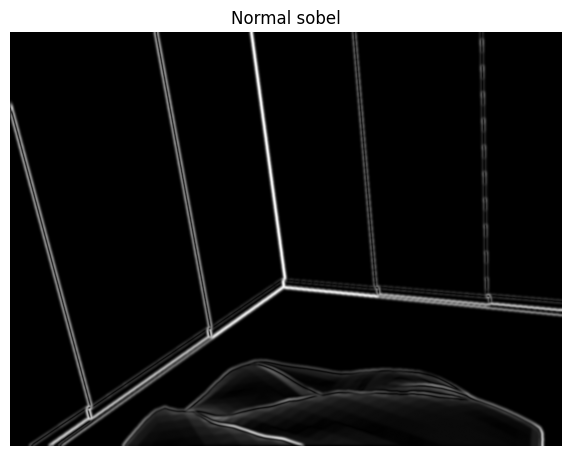

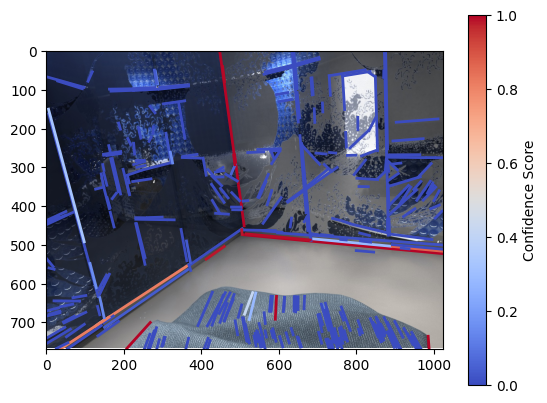


Processing image: ai_003_001 for frame 0001
data/ai_003_001/ai_003_001/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_003_001/ai_003_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
data/ai_003_001/ai_003_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
(768, 1024)
Detected 0 lines; 0 classified as structural.


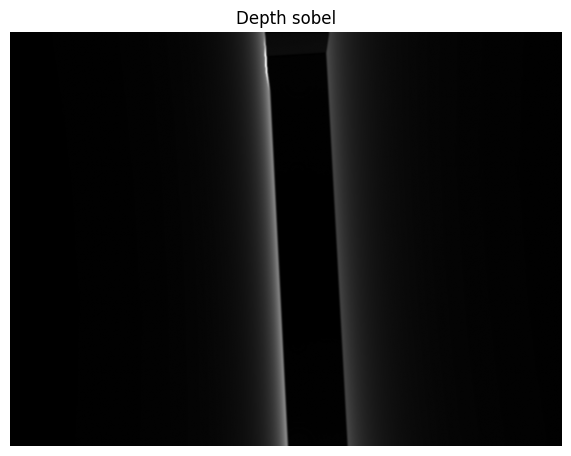

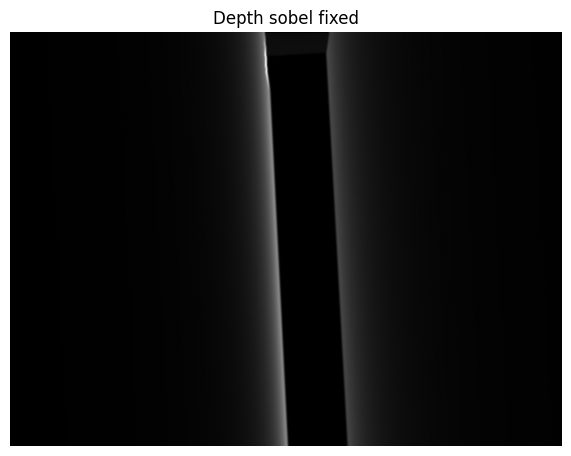

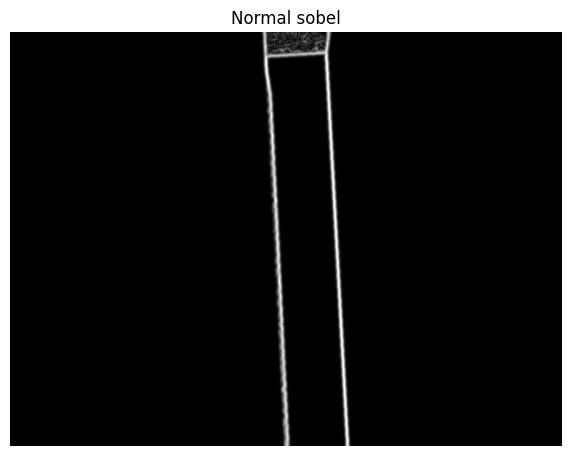

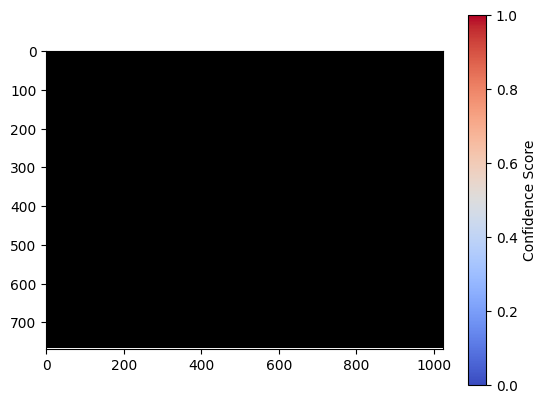


Processing image: ai_003_003 for frame 0001
data/ai_003_003/ai_003_003/images/scene_cam_00_final_preview/frame.0001.color.jpg
Color image not found in data/ai_003_003 with camera view scene_cam_00_final_preview
data/ai_003_003/ai_003_003/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
Depth file not found in data/ai_003_003 with camera view scene_cam_00_geometry_hdf5
data/ai_003_003/ai_003_003/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
Normal file not found in data/ai_003_003 with camera view scene_cam_00_geometry_hdf5


AttributeError: 'NoneType' object has no attribute 'shape'

In [62]:
# FIRST method

# Base folder where all downloaded image folders reside
base_data_dir = "data"
# List of downloaded image IDs (folder names)
image_ids = desired_images

for image_id in image_ids:
    image_dir = os.path.join(base_data_dir, image_id)
    print(f"\nProcessing image: {image_id} for frame {frame_str}")
    
    cam_view_color = "scene_cam_00_final_preview"
    cam_view_geom = "scene_cam_00_geometry_hdf5"

    color_img = load_color_image(image_dir, image_id, frame_str, cam_view_color)
    depth_map = load_depth_map(image_dir, image_id, frame_str, cam_view_geom)
    normal_map = load_normal_map(image_dir, image_id, frame_str, cam_view_geom)
    # default_h, default_w = 768, 1024
    # h, w = default_h, default_w 
    # color_img = load_color_image(image_dir, image_id, frame_str, cam_view_color)
    # color_img = cv2.resize(color_img, (h,w))
    
    h, w = color_img.shape[:2]

    fov_x = np.pi / 3  # set fov_x to pi/3 to match DIODE dataset (60 degrees)
    f = w / (2 * np.tan(fov_x / 2))
    fov_y = 2 * np.arctan(h / (2 * f))
    default_K = np.array([[f, 0, w / 2], [0, f, h / 2], [0, 0, 1]])
    R180x = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])


    # depth_map = cv2.resize(depth_map, (h,w))
    depth_map_fixed = raydepth2depth(depth_map, default_K)

    # normal_map = cv2.resize(normal_map, (h,w))
    
    if color_img is None or depth_map is None or normal_map is None:
        print("Missing data for", image_id, "; skipping.")
        continue
    
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
    
    
    
    # Detect lines with DeepLSD
    input_tensor = torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.
    with torch.no_grad():
        out = net({'image': input_tensor})
        # Get predicted lines from the output. If they are torch.Tensor, convert to numpy.
        pred_lines = out['lines'][0]
        if isinstance(pred_lines, torch.Tensor):
            pred_lines = pred_lines.cpu().numpy()
    
    
    
    # Compute Sobel variation maps for depth and normal.
    sobel_depth_map = compute_variation(depth_map, 11, depth=True)
    sobel_depth_map_fixed = compute_variation(depth_map_fixed, 11, depth=True)
    sobel_normal_map = compute_variation(normal_map, 27)

    
    
    if len(sobel_normal_map.shape) == 3 and sobel_normal_map.shape[2] > 1:
        sobel_normal_map = LA.norm(sobel_normal_map, axis=2)
        print(sobel_normal_map.shape)
    
    plot_images([sobel_depth_map], ["Depth sobel"], cmaps='gray')
    plot_images([sobel_depth_map_fixed], ["Depth sobel fixed"], cmaps='gray')
    plot_images([(sobel_normal_map)], ['Normal sobel'], cmaps='gray')

    threshold_depth = np.percentile(sobel_depth_map_fixed, 0)  # 99th percentile threshold
    threshold_normal = np.percentile(sobel_normal_map, 10)  # 99th percentile threshold

        
    
    
    # For each predicted line, compute variation along the line
    isdepth = []
    isnormal = []
    isstruct = []
    scores = []

    for l in pred_lines:
        ld, ln = sobel_line(sobel_depth_map_fixed, sobel_normal_map, l)
        # depthbool = np.mean(ld) > 0.0001
        # normalbool = np.mean(ln) > 0.0001
        # depthbool = np.mean(ld) > 1
        # normalbool = np.mean(ln) > 14000000000
        # depthbool = np.mean(ld) > 0.000004
        # normalbool = np.mean(ln) > 0.000024

        # depthbool = np.mean(ld) > threshold_depth
        # normalbool = np.mean(ln) > threshold_normal
        # isdepth.append(depthbool)
        # isnormal.append(normalbool)
        # isstruct.append(depthbool or normalbool)

        # scores.append(max(sigmoid(np.mean(ln), lam=90000 ,tau=0.000024), sigmoid(np.mean(ld), lam=9000000 ,tau=0.000004)))  # Soft thresholding
        scores.append(max(sigmoid(np.max(ln), lam=25 ,tau=0.5), sigmoid(np.max(ld), lam=250 ,tau=0.05)))  # Soft thresholding 0.01

    
    print(f"Detected {len(pred_lines)} lines; {sum(isstruct)} classified as structural.")
    
    
   
    plot_lines_confidence(color_img, pred_lines, scores)

# Second method

# MAX of depth/normal + SUM of normal vector

In [ ]:

# MAX of depth/normal + SUM of normal vector


base_data_dir = "data"
image_ids = desired_images


# Define arrays for each parameter
depth_thresholds = [5]     
normal_thresholds = [6]      
thickness_values = [5]             


plot_process(image_ids, base_data_dir, depth_thresholds, normal_thresholds,
             thickness_values, n_columns=1, depth_normal_func=np.max, norm_agg_func=np.sum)
# For each image 



# MEAN of depth/normal + SUM of normal vector

In [ ]:
# MEAN of depth/normal + SUM of normal vector

depth_thresholds = [0.0001]     
normal_thresholds = [0.00005]    
thickness_values = [1]   

plot_process(image_ids, base_data_dir, depth_thresholds, normal_thresholds,
             thickness_values, n_columns=1, depth_normal_func=np.mean, depth_normal_func_str="Mean",
            norm_agg_func=np.sum)

# MEAN of depth/normal + NORM of normal vector

In [ ]:
# MEAN of depth/normal + NORM of normal vector
image_ids = desired_images

depth_thresholds = [0.0005]     
normal_thresholds = [0.0001]    
thickness_values = [1]   

plot_process(image_ids, base_data_dir, depth_thresholds, normal_thresholds,
             thickness_values, n_columns=1, depth_normal_func=np.mean, depth_normal_func_str="Mean",
            norm_agg_func=LA.norm)

# MAX of depth/normal + NORM of normal vector

In [ ]:
# MEAN of depth/normal + NORM of normal vector
image_ids = desired_images

depth_thresholds = [5]     
normal_thresholds = [5]    
thickness_values = [5]   

plot_process(image_ids, base_data_dir, depth_thresholds, normal_thresholds,
             thickness_values, n_columns=1, depth_normal_func=np.max, depth_normal_func_str="Max",
            norm_agg_func=LA.norm)
